In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from umap import UMAP
import plotly.express as px
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder

In [30]:
male_players_24 = pd.read_csv("male_players_preprocessed.csv")

In [31]:
#here are the relevant features that we will use in our clustering
keeping_features = [
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision',
        'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

X = male_players_24[keeping_features]

# compare the ground truth for metrics
true_labels = male_players_24['broad_position']

In [32]:
# check the range to see if we need standardization
min_value = X.min().min()
max_value = X.max().max()

print("Minimum value in X:", min_value)
print("Maximum value in X:", max_value)

Minimum value in X: 2
Maximum value in X: 97


In [33]:
# we don't need to standardize the values since the range is 0-100
# X_scaled = StandardScaler().fit_transform(X)
# X_scaled is not scaled actually
X_scaled = X.copy()

In [34]:
#label encodings for 2D data
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(true_labels)

### PCA

In [35]:
pca = PCA(n_components=0.90) # setting threshold to 90%
X_pca = pca.fit_transform(X_scaled)

In [36]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained by all selected components:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.67850301 0.16480112 0.04595538 0.03210933]
Total variance explained by all selected components: 0.9213688512713296


The explained variance ratio is a metric that tells you how much of the total variance in your dataset is captured by each principal component generated by PCA (Principal Component Analysis). Specifically, it indicates the proportion of the dataset's variance that lies along each principal component axis.

The first principal component captures approximately 67.85% of the variance in the dataset, second principal component, 0.16%, and so on. This means that a significant portion of the information (or variability) in your dataset can be represented along this first principal component dimension.

Text(0.5, 1.0, 'PCA Projection - First Two Principal Components')

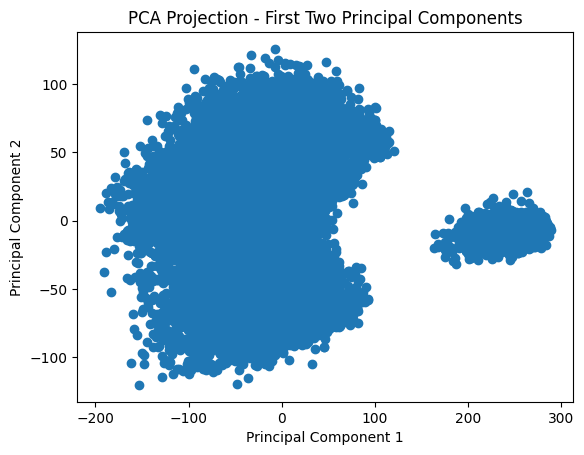

In [37]:
# scatter plot the pc1 and pc2
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection - First Two Principal Components')

Text(0, 0.5, 'PC 2')

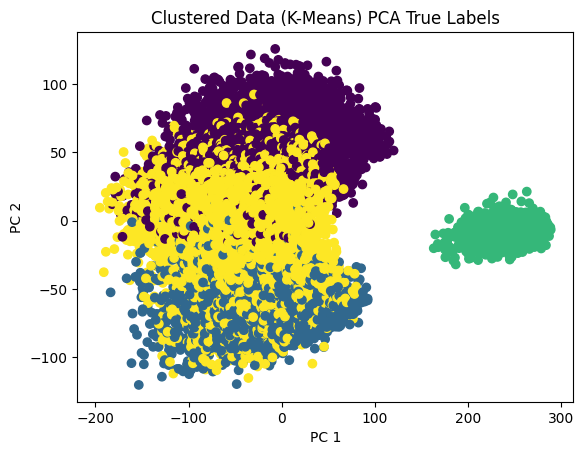

In [38]:
# true label for pca scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_encoded)
plt.title('Clustered Data (K-Means) PCA True Labels')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

The above scatter plot is not enough to do the dimensionality reduction for 4 ground truth positions.  We can only observe 2 clusters and the small cluster will be goal keeper and the big cluster most likely contain the other 3 positions.

Now do another dimensionality reduction approach.

### UMAP

In [39]:
umap = UMAP(n_neighbors=10, min_dist=0.99, n_components=2) # find the right parameter

# Fit UMAP and transform your data
X_umap = umap.fit_transform(X_scaled)

Text(0, 0.5, 'UMAP Component 2')

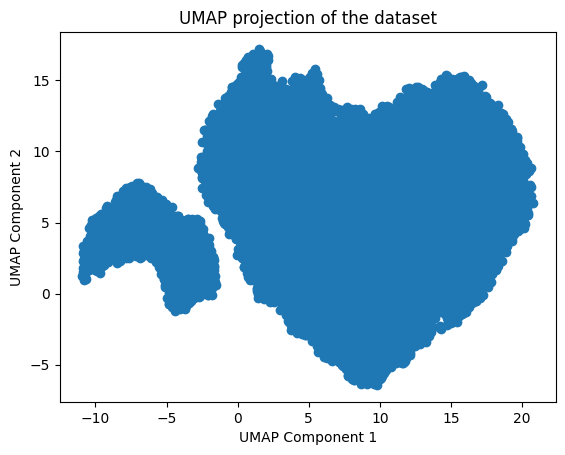

In [40]:
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

Text(0, 0.5, 'Component 2')

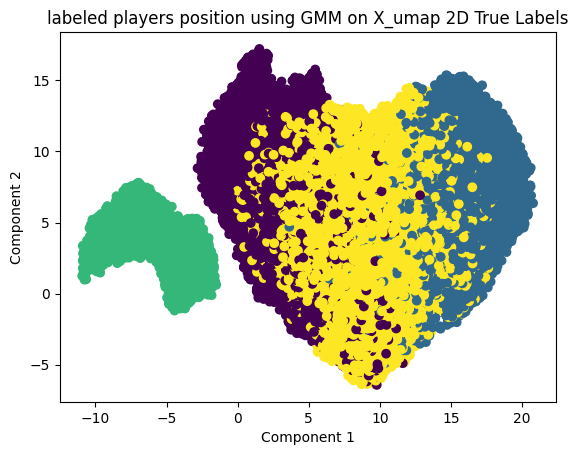

In [41]:
# True labels 2D GMMs
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_encoded)
plt.title('labeled players position using GMM on X_umap 2D True Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Since trying with multiple parameters doesn't separate the exact 4 clusters, try the 3d versions with n_components=3

In [42]:
umap_3d = UMAP(n_neighbors=10, min_dist=0.99, n_components=3) # # find the right parameter

# Fit UMAP and transform your data
X_umap_3d = umap_3d.fit_transform(X_scaled)

In [32]:
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    title='3D UMAP projection of the dataset'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    )
)

In [28]:
# plot the true label in 3d
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    color=true_labels,
    title='3D UMAP Projection of the Dataset (Colored by True Labels)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

### t-SNE

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  # Setting random_state for reproducibility
X_tsne = tsne.fit_transform(X)

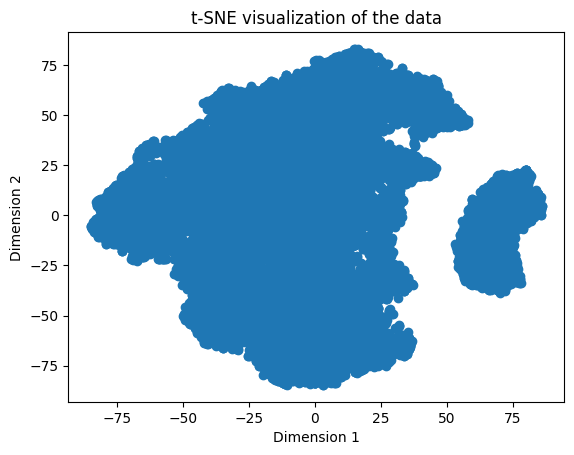

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])  # Plotting the two dimensions
plt.title('t-SNE visualization of the data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_encoded)  # Plotting the two dimensions
plt.title('t-SNE visualization of the data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
tsne3d = TSNE(n_components=3, random_state=42)  # Setting random_state for reproducibility
X_tsne_3d = tsne3d.fit_transform(X)

In [ ]:
fig = px.scatter_3d(
    x=X_tsne_3d[:, 0],
    y=X_tsne_3d[:, 1],
    z=X_tsne_3d[:, 2],
     color=true_labels,
    title='3D t-SNE projection of the dataset'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    )
)

## Clustering from here

### K means


In [37]:
#K-Means with no dimensionality reduction
kmeans = KMeans(n_clusters=4)
cluster_labels_k_none = kmeans.fit_predict(X)
ari_k = adjusted_rand_score(true_labels, cluster_labels_k_noreduc)
print(ari_k)

c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



0.37635901274764677


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score K means using PCA dataset: 0.43
Adjusted Rand Index: 0.38


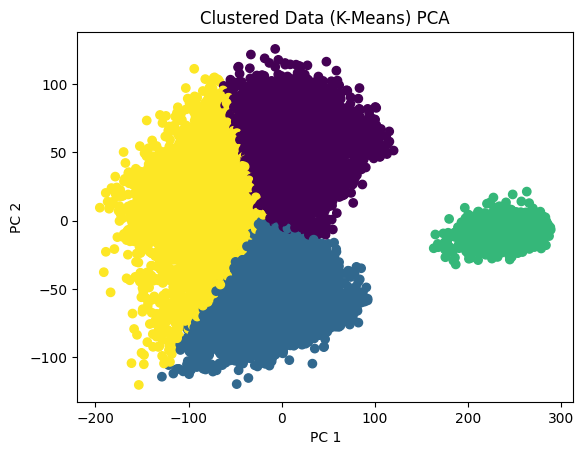

In [38]:
kmeans = KMeans(n_clusters=4)
cluster_labels_k_pca = kmeans.fit_predict(X_pca)


# scatter plot of the predicted clustered using k means using pca structure
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_k_pca)
plt.title('Clustered Data (K-Means) PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

silhouette_avg_k_pca = silhouette_score(X_pca, cluster_labels_k_pca)
print(f'Silhouette Score K means using PCA dataset: {silhouette_avg_k_pca:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k_pca)
print(f'Adjusted Rand Index: {ari_k:.2f}')

In [ ]:
# scatter plot of the predicted clustered using k means using pca structure
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_k)
plt.title('Clustered Data (K-Means) PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
# calculate metrics 
silhouette_avg_k_pca = silhouette_score(X_pca, cluster_labels_k)
print(f'Silhouette Score K means using PCA dataset: {silhouette_avg_k_pca:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k)
print(f'Adjusted Rand Index: {ari_k:.2f}')

In [10]:
# Grid Search
param_grid_kmeans_pca = {
    'n_components': [2,3,4,5]
}

best_ari_pca_kmeans = 0
best_ari_params_pca_kmeans = {}
best_ss_pca_kmeans = 0
best_ss_params_pca_kmeans = {}
ari_dict_pca_kmeans = {}
ss_dict_pca_kmeans = {}
kmeans = KMeans(random_state=42, n_clusters=4)

for params in ParameterGrid(param_grid_kmeans_pca):
    pca = PCA(random_state=42, **params)
    X_pca = pca.fit_transform(X_scaled)
    pred = kmeans.fit_predict(X_pca)
    ari = adjusted_rand_score(true_labels, pred)  # Assuming true_labels are available
    ss_pca = silhouette_score(X_pca, pred)

    ari_dict_pca_kmeans[str(params)] = ari
    ss_dict_pca_kmeans[str(params)] = ss_pca

    if ari > best_ari_pca_kmeans:
        best_ari_pca_kmeans = ari
        best_ari_params_pca_kmeans = params

    
    if ss_pca > best_ss_pca_kmeans:
        best_ss_pca_kmeans = ss_pca
        best_ss_params_pca_kmeans = params
    print(str(params), str(ari), str(ss_pca))

print("Best ari Parameters:", best_ari_params_pca_kmeans, "score", best_ari_pca_kmeans)
print("Best ss Parameters :", best_ss_params_pca_kmeans, "score", best_ss_pca_kmeans)

c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'n_components': 2} 0.37597039331961835 0.4815124428227003


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'n_components': 3} 0.37308408705814333 0.46452251732644956


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'n_components': 4} 0.37575188792052894 0.42496747306549054


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'n_components': 5} 0.3759845561944448 0.4041456776677009
Best ari Parameters: {'n_components': 5} score 0.3759845561944448
Best ss Parameters : {'n_components': 2} score 0.4815124428227003


In [13]:
# Grid Search
param_grid_kmeans_umap = {
    'n_components': [2,3,4,5],
    'n_neighbors': [5,10,15],
    'min_dist': [0.1, 0.5, 1],
}

best_ari_umap_kmeans = 0
best_ari_params_umap_kmeans = {}
best_ss_umap_kmeans = 0
best_ss_umap_pca_kmeans = {}
ari_dict_umap_kmeans = {}
ss_dict_umap_kmeans = {}
kmeans = KMeans(random_state=42, n_clusters=4)


for params in ParameterGrid(param_grid_kmeans_umap):
    umap = UMAP(n_jobs=-1, **params)
    X_umap = umap.fit_transform(X_scaled)
    pred = kmeans.fit_predict(X_umap)
    ari = adjusted_rand_score(true_labels, pred)  # Assuming true_labels are available
    ss_umap = silhouette_score(X_umap, pred)

    ari_dict_umap_kmeans[str(params)] = ari
    ss_dict_umap_kmeans[str(params)] = ss_umap

    if ari > best_ari_umap_kmeans:
        best_ari_umap_kmeans = ari
        best_ari_params_umap_kmeans = params

    
    if ss_umap > best_ss_umap_kmeans:
        best_ss_umap_kmeans = ss_pca
        best_ss_params_umap_kmeans = params
    print(str(params), str(ari), str(ss_umap))

print("Best ari Parameters:", best_ari_params_umap_kmeans, "score", best_ari_umap_kmeans)
print("Best ss Parameters :", best_ss_params_umap_kmeans, "score", best_ss_umap_kmeans)

c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5} 0.40791027654712825 0.5189211


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 10} 0.40014294604827605 0.5194087


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 15} 0.4027154664024374 0.51743805


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 5} 0.39156840327985903 0.50320166


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 10} 0.3982641911139968 0.5092721


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15} 0.3993154279896226 0.5102724


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 4, 'n_neighbors': 5} 0.39339821925023244 0.49552757


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 4, 'n_neighbors': 10} 0.39733014413975304 0.5065249


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 4, 'n_neighbors': 15} 0.39866933652924336 0.5108821


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 5, 'n_neighbors': 5} 0.3949763598776074 0.49402228


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 5, 'n_neighbors': 10} 0.3964039923321715 0.5080403


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.1, 'n_components': 5, 'n_neighbors': 15} 0.3990567751230434 0.5090288


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 2, 'n_neighbors': 5} 0.3945082519813165 0.45369944


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 2, 'n_neighbors': 10} 0.39388316974161813 0.47840074


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 2, 'n_neighbors': 15} 0.39493858937750576 0.47760922


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 3, 'n_neighbors': 5} 0.3876314839541186 0.43090206


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 3, 'n_neighbors': 10} 0.38857047211031515 0.4486439


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 3, 'n_neighbors': 15} 0.3895437947314419 0.45879987


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 4, 'n_neighbors': 5} 0.389864239456863 0.42112705


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 4, 'n_neighbors': 10} 0.3878590959176221 0.44285542


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 4, 'n_neighbors': 15} 0.38497179030882084 0.4552752


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 5, 'n_neighbors': 5} 0.3878108498157237 0.41219205


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 5, 'n_neighbors': 10} 0.38905882170747486 0.44094217


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 0.5, 'n_components': 5, 'n_neighbors': 15} 0.3890517544210648 0.4505872


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 2, 'n_neighbors': 5} 0.3672004150841511 0.41477814


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 2, 'n_neighbors': 10} 0.390014225768894 0.43727607


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 2, 'n_neighbors': 15} 0.3923335414602105 0.4409097


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 3, 'n_neighbors': 5} 0.3811693733970526 0.359674


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 3, 'n_neighbors': 10} 0.38265502348843766 0.39862004


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 3, 'n_neighbors': 15} 0.38384909650288435 0.40759933


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 4, 'n_neighbors': 5} 0.3927849327176725 0.3423141


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 4, 'n_neighbors': 10} 0.3828529365401115 0.37565094


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 4, 'n_neighbors': 15} 0.37772830416989445 0.39706704


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 5, 'n_neighbors': 5} 0.3918298734681646 0.3194823


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 5, 'n_neighbors': 10} 0.3859822754711795 0.363638


c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'min_dist': 1, 'n_components': 5, 'n_neighbors': 15} 0.3797622056283912 0.37919465
Best ari Parameters: {'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5} score 0.40791027654712825
Best ss Parameters : {'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5} score 0.4041456776677009


Text(0, 0.5, 'Component 2')

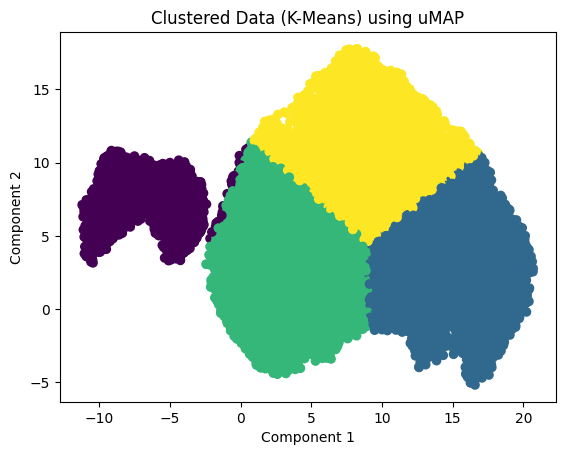

In [ ]:
# using X_umap scatter plot of the predicted k-means clustered
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_k)
plt.title('Clustered Data (K-Means) using uMAP')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_umap = silhouette_score(X_umap, cluster_labels_k)
print(f'Silhouette Score U-MAP means: {silhouette_avg_umap:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k)
print(f'Adjusted Rand Index: {ari_k:.2f}')

Silhouette Score K means: 0.44
Adjusted Rand Index: 0.39


Text(0, 0.5, 'PC 2')

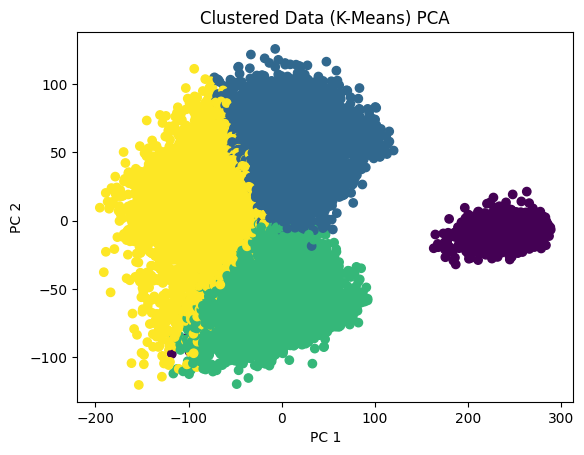

Silhouette Score K means using PCA dataset: 0.42
Adjusted Rand Index: 0.39


### Gaussian Mixture Model

In [40]:
gmm = GaussianMixture(random_state=42, n_components=4)
cluster_labels_gmm_none = gmm.fit_predict(X_umap)
ari_gmm_none = adjusted_rand_score(true_labels, cluster_labels_gmm_none)
print(ari_gmm_none)

0.4053806432043382


In [14]:
# Grid Search
param_grid_gmm_pca = {
    'n_components': [2,3,4,5]
}

param_grid_gmm = {
    'n_components': [4], 
    'covariance_type': ['full', 'diag'],
    'tol': [0.001], 
    'init_params': ['kmeans', 'random']
}


best_ari_pca_gmm = 0
best_ari_params_pca_gmm = {}
best_ss_pca_gmm = 0
best_ss_params_pca_gmm = {}
ari_dict_pca_gmm = {}
ss_dict_pca_gmm = {}


for params_1 in ParameterGrid(param_grid_gmm_pca):
    for params_2 in ParameterGrid(param_grid_gmm):
        pca = PCA(random_state=42, **params_1)
        gmm = GaussianMixture(random_state=42, **params_2)
        X_pca = pca.fit_transform(X_scaled)
        pred = gmm.fit_predict(X_pca)
        ari = adjusted_rand_score(true_labels, pred)  # Assuming true_labels are available
        ss_pca = silhouette_score(X_pca, pred)

        ari_dict_pca_gmm[str([params_1, params_2])] = ari
        ss_dict_pca_gmm[str([params_1, params_2])] = ss_pca

        if ari > best_ari_pca_gmm:
            best_ari_pca_gmm = ari
            best_ari_params_pca_gmm = [params_1, params_2]

        
        if ss_pca > best_ss_pca_gmm:
            best_ss_pca_gmm = ss_pca
            best_ss_params_pca_gmm = [params_1, params_2]
        print(str([params_1, params_2]), str(ari), str(ss_pca))

print("Best ari Parameters:", best_ari_params_pca_gmm, "score", best_ari_pca_gmm)
print("Best ss Parameters :", best_ss_params_pca_gmm, "score", best_ss_pca_gmm)

[{'n_components': 2}, {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.40768003809020337 0.4481985184720046
[{'n_components': 2}, {'covariance_type': 'full', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] 0.38459396576244603 0.3525226976895483
[{'n_components': 2}, {'covariance_type': 'diag', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.4059099585152809 0.44154345173222004
[{'n_components': 2}, {'covariance_type': 'diag', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] 0.3898061918894917 0.36806902174980455
[{'n_components': 3}, {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.4170191328571051 0.4143398109110443
[{'n_components': 3}, {'covariance_type': 'full', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] 0.19644518586565538 0.34047069209592107
[{'n_components': 3}, {'covariance_type': 'diag', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.3

In [15]:
# Grid Search

#the parameter grid for UMAP that is being used with GMM is smaller than the one used with KMeans, since GMM's  
#hyperparameters are being tuned and there is an increased amount of combined hyperparameter combinations 
#for UMAP and GMM, which will increase the runtime significantly
#we aren't tuning the min_dist hyperparameter in UMAP since from the tuning with UMAP and KMeans, the models where 
# min_dist was 0.1 had significantly higher silhouette scores than the others
param_grid_gmm_umap = {
    'n_components': [2,3,4,5],
    'n_neighbors': [5,10,15],
    'min_dist': [0.1]
}

param_grid_gmm = {
    'n_components': [4], 
    'covariance_type': ['full', 'diag'],
    'tol': [0.001], 
    'init_params': ['kmeans', 'random']
}


best_ari_umap_gmm = 0
best_ari_params_umap_gmm = {}
best_ss_umap_gmm = 0
best_ss_params_umap_gmm = {}
ari_dict_umap_gmm = {}
ss_dict_umap_gmm = {}


for params_1 in ParameterGrid(param_grid_gmm_umap):
    for params_2 in ParameterGrid(param_grid_gmm):
        umap = UMAP(n_jobs=-1, **params_1)
        gmm = GaussianMixture(random_state=42, **params_2)
        X_umap = umap.fit_transform(X_scaled)
        pred = gmm.fit_predict(X_umap)
        ari = adjusted_rand_score(true_labels, pred)  # Assuming true_labels are available
        ss_umap = silhouette_score(X_umap, pred)

        ari_dict_umap_gmm[str([params_1, params_2])] = ari
        ss_dict_umap_gmm[str([params_1, params_2])] = ss_umap

        if ari > best_ari_umap_gmm:
            best_ari_pca_gmm = ari
            best_ari_params_pca_gmm = [params_1, params_2]

        
        if ss_umap > best_ss_umap_gmm:
            best_ss_pca_gmm = ss_pca
            best_ss_params_pca_gmm = [params_1, params_2]
        print(str([params_1, params_2]), str(ari), str(ss_umap))

print("Best ari Parameters:", best_ari_params_umap_gmm, "score", best_ari_umap_gmm)
print("Best ss Parameters :", best_ss_params_umap_gmm, "score", best_ss_umap_gmm)

[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}, {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.41013890564700917 0.5064318
[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}, {'covariance_type': 'full', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] 0.260856360121649 -0.049645834
[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}, {'covariance_type': 'diag', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.4189849577176865 0.5039337
[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}, {'covariance_type': 'diag', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] 0.25120532780025845 0.14455964
[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 10}, {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] 0.4170627221331803 0.508686
[{'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 10}, {'covariance_type': 'full', 'init_params': 'random', 'n_components': 4, 

In [28]:
best_ari_umap_gmm = max(ari_dict_umap_gmm.values())
best_ari_position = list(ari_dict_umap_gmm.values()).index(best_ari_umap_gmm)
best_ari_params_umap_gmm = list(ari_dict_umap_gmm.keys())[best_ari_position]
print("Best ari Parameters:", best_ari_params_umap_gmm, "score", best_ari_umap_gmm)

best_ss_umap_gmm = max(ss_dict_umap_gmm.values())
best_ss_position = list(ss_dict_umap_gmm.values()).index(best_ss_umap_gmm)
best_ss_params_umap_gmm = list(ss_dict_umap_gmm.keys())[best_ss_position]
print("Best ss Parameters:", best_ss_params_umap_gmm, "score", best_ss_umap_gmm)


Best ari Parameters: [{'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15}, {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'tol': 0.001}] score 0.4980403879430264
Best ss Parameters: [{'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15}, {'covariance_type': 'full', 'init_params': 'random', 'n_components': 4, 'tol': 0.001}] score 0.62727594


In [ ]:
gmm = GaussianMixture(**best_params_2d)
cluster_labels_gmm = gmm.fit_predict(X_umap)
cluster_labels_gmm

array([0, 0, 3, ..., 0, 1, 1], dtype=int64)

Text(0, 0.5, 'Component 2')

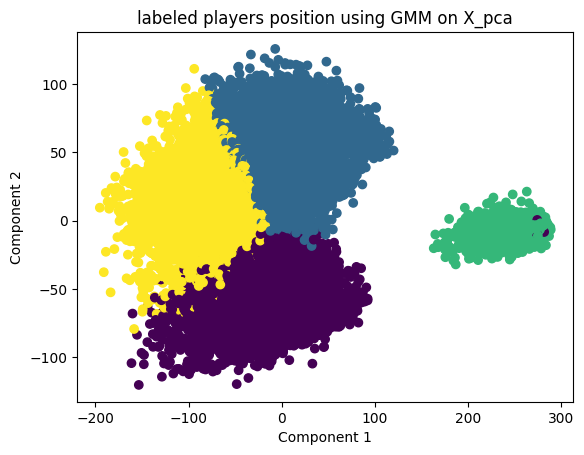

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_pca')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_gmm_pca = silhouette_score(X_pca, cluster_labels_gmm)
print(f'Silhouette Score (GMM) using X_pca: {silhouette_avg_gmm_pca:.2f}')

ari_gmm = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM): {ari_gmm:.2f}')

Silhouette Score (GMM) using X_pca: 0.41
Adjusted Rand Index (GMM): 0.40


Text(0, 0.5, 'Component 2')

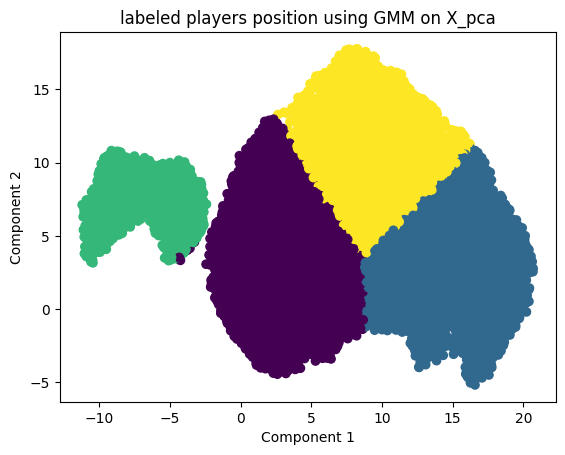

In [ ]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_umap')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Text(0, 0.5, 'Component 2')

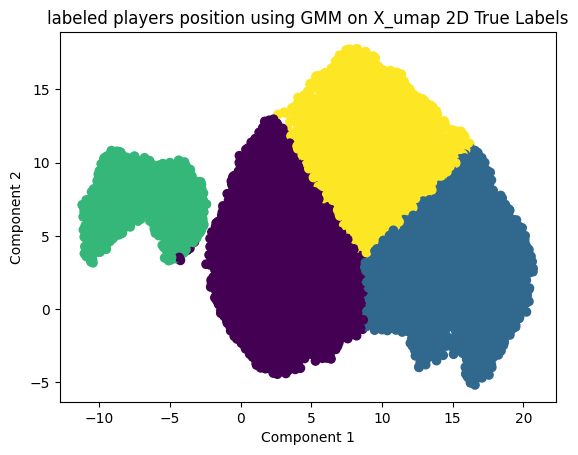

In [ ]:
# True labels 2D GMMs
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_umap 2D True Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_gmm = silhouette_score(X_umap, cluster_labels_gmm)
print(f'Silhouette Score (GMM): {silhouette_avg_gmm:.2f}')

ari_gmm = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM): {ari_gmm:.2f}')

Silhouette Score (GMM): 0.43
Adjusted Rand Index (GMM): 0.40


In [ ]:
# 3D GMM
gmm_3d = GaussianMixture(**best_params_3d)
cluster_labels_gmm_3d = gmm_3d.fit_predict(X_umap_3d)
cluster_labels_gmm_3d

array([1, 1, 2, ..., 1, 0, 0], dtype=int64)

In [ ]:
# 3D scatter plot for cluster_labels_gmm
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    color=cluster_labels_gmm_3d,  # Color points by GMM cluster label
    title='3D UMAP Projection of the Dataset (Colored by GMM Clusters)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

In [ ]:
# calculate metrics 
silhouette_avg_3d = silhouette_score(X_umap_3d, cluster_labels_gmm)
print(f'Silhouette Score (GMM on 3D UMAP): {silhouette_avg_3d:.2f}')

# adjusted rand index is same as 2d
ari_3d = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM on 3D UMAP): {ari_3d:.2f}')

Silhouette Score (GMM on 3D UMAP): 0.40
Adjusted Rand Index (GMM on 3D UMAP): 0.40


M, F looks very mixed. It is hard to distinguish because there are many overlapping stats for positions M, F.

what can we do?
- select better features that can distinguish the most out of all positions

In [ ]:
raise Exception('harry work till here')

Exception: harry work till here

### End of Harry's section
---

In [47]:
#create 2 Pipelines with Scaling, PCA, and our clustering algorithms

pipe_kmeans = Pipeline([
    
    ('PCA', PCA()),
    ('kmeans', KMeans(random_state=42))
])

pipe_gmm = Pipeline([
    ("scaler", StandardScaler()),
    ('PCA', PCA(n_components=2)),
    ('gmm', GaussianMixture(random_state=42))
])

In [51]:
#make 2 GridSearchCV objects for each pipeline

param_grid_kmeans = {
    "PCA__n_components": [2, 3, 4],
    "kmeans__n_clusters": [4]
}

param_grid_gmm = {
    "PCA__n_components": [2, 3, 4],
    "gmm__n_components": [4],
}
GSCV_kmeans = GridSearchCV(pipe_kmeans, param_grid_kmeans, n_jobs=-1)
GSCV_gmm = GridSearchCV(pipe_gmm, param_grid_gmm, n_jobs=-1)

In [52]:
fitted_kmeans = GSCV_gmm.fit(X)
print("Best hyperparameters: \n" ,fitted_kmeans.best_params_, 
      "Best score: \n" ,fitted_kmeans.best_score_)

In [46]:
X

attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                      78                   94                          73   
1                      47                   96                          83   
2                      95                   85                          55   
3                      83                   89                          60   
4                      75                   91                          90   
...                   ...                  ...                         ...   
18345                  23                   20                          42   
18346                  26                   25                          45   
18347                  32                   49                          41   
18348                  36                   32                          42   
18349                  35                   31                          42   

       attacking_short_passing  attacking_volleys  skill_dribbling  \
0                           86                 84               93   
1                           77                 90               79   
2                           94                 83               86   
3                           91                 86               96   
4                           89                 88               87   
...                        ...                ...              ...   
18345                       27                 27               20   
18346                       32                 30               26   
18347                       44                 37               42   
18348                       54                 36               43   
18349                       51                 26               43   

       skill_curve  skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0               80                 69                  71                  92   
1               77                 62                  53                  82   
2               92                 83                  94                  92   
3               93                 93                  90                  93   
4               82                 73                  76                  91   
...            ...                ...                 ...                 ...   
18345           23                 26                  20                  25   
18346           32                 26                  25                  31   
18347           31                 34                  31                  44   
18348           34                 35                  50                  45   
18349           32                 34                  50                  42   

       ...  ldm  cdm  rdm  rwb  lb  lcb  cb  rcb  rb  gk  
0      ...   63   63   63   68  63   54  54   54  63  18  
1      ...   63   63   63   62  60   62  62   62  60  19  
2      ...   80   80   80   79  75   70  70   70  75  21  
3      ...   63   63   63   64  59   49  49   49  59  19  
4      ...   64   64   64   64  60   55  55   55  60  18  
...    ...  ...  ...  ...  ...  ..  ...  ..  ...  ..  ..  
18345  ...   39   39   39   41  43   47  47   47  43  13  
18346  ...   43   43   43   44  46   47  47   47  46  13  
18347  ...   31   31   31   35  33   27  27   27  33  13  
18348  ...   45   45   45   45  45   44  44   44  45  14  
18349  ...   46   46   46   46  46   46  46   46  46  14  

[18350 rows x 59 columns]

In [ ]:
param_grid_test = {
    "PCA__n_components": [2],
    "kmeans__n_clusters": [4]
}

GSCV_test = GridSearchCV(pipe_kmeans, param_grid_test, n_jobs=-1, scoring='adjusted_rand_score',

               verbose=3)

In [ ]:
fit_test = GSCV_test.fit(X)
print(GSCV_test.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning:

One or more of the test scores are non-finite: [nan]



nan


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
fitted_gmm = GSCV_gmm.fit(X)
fitted_gmm.best_params_

ValueError: Invalid parameter 'gmm_covariance_type' for estimator Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=2)),
                ('gmm', GaussianMixture(random_state=42))]). Valid parameters are: ['memory', 'steps', 'verbose'].

c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.46496272548703627


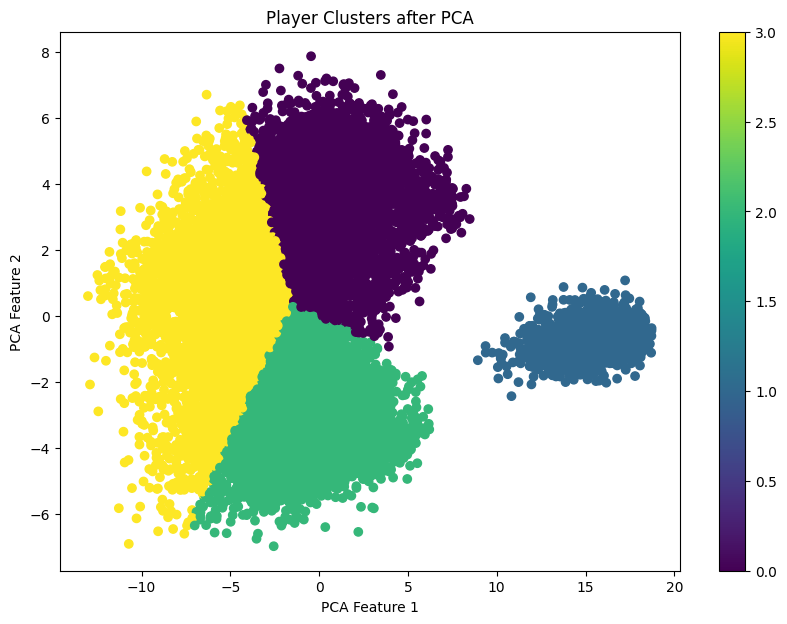

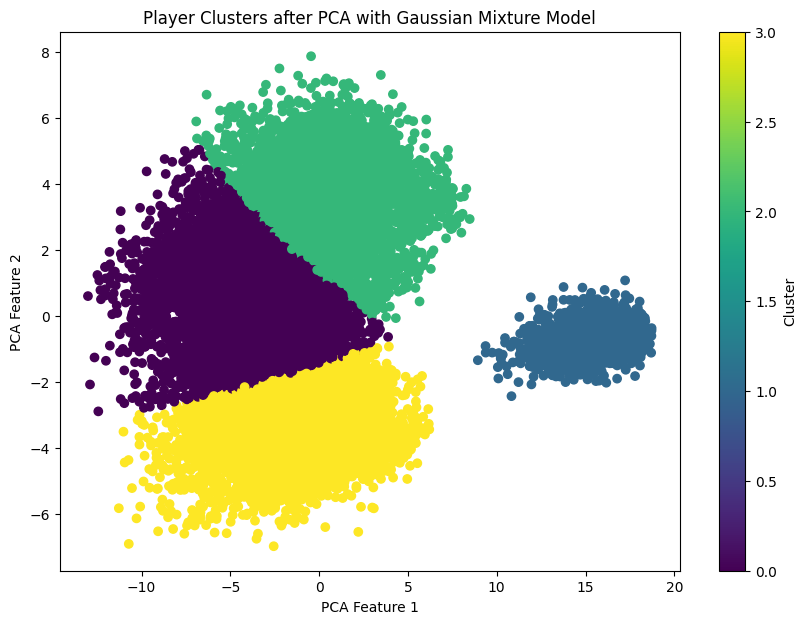

In [ ]:


# Adding cluster labels to the original dataframe
male_players_24['kmeans_cluster'] = kmeans.labels_

# Evaluating the clustering
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Player Clusters after PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()

# Initialize the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)

# Fit the GMM model to the PCA-transformed data
gmm.fit(X_pca)

# Predict the cluster labels
gmm_labels = gmm.predict(X_pca)

# Adding cluster labels to the original dataframe
male_players_24['gmm_cluster'] = gmm_labels

# Plotting the GMM clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('Player Clusters after PCA with Gaussian Mixture Model')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()
